# Проект: Определение перспективных тарифов

В данной исследовательской работе нам предстоит проанализировать поведение пользователей сотовой связи на примере 2-х тарифов компании "Мегалайн". По возможности - выработать рекомендации для изменения ценовой политики.
Таким образом, наша цель выглядит следующим образом:

по выборочной базе поведения клиентов сравнить доходы и выгоду по обоим тарифам как для компании, так и для пользователей

**Задачи:**

1) Подготовить данные путем их предобработки ( привести к нужным типам, провести дополнительные расчеты)

2) Составить таблицы с данными по месяцам и использованию пакетов тарифов

3) Построить графики для признаков расходов разных тарифов

4) Посчитать перерасход по каждой из позиции для каждого тарифа

5) Определить доходности у абонентов тарифов (совокупную за год и среднюю в месяце)

6) Посчитать прибыль от групп абонентов (тарифы, гео)

7) Проверить значимость полученных результатов

8) Предложить улучшения существующих тарифов

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_data(path):
    var = pd.read_csv(path)
    var.info()
    return var

Данные будем получить с помощью функции, которую мы написали ранее. Функция принимает путь (разделитель в данном случае не нужно указывать), сохраняет его в переменной в по имени, а также выводит информацию по столбцам.

Это особенно удобно, чтобы сразу же оценить объем пропусков и структуру реляционной таблицы

In [3]:
users = get_data('/datasets/users.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
calls = get_data('/datasets/calls.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
internet = get_data('/datasets/internet.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
sms = get_data('/datasets/messages.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
tarifs = get_data('/datasets/tariffs.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [8]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [9]:
users['tariff'].value_counts(normalize=True)

smart    0.702
ultra    0.298
Name: tariff, dtype: float64

***Объем выборки диспропорционален в пользу абонентов с тарифом `smart`. Если выгрузка была произведена правильно, то наша выборка повторяет структуру всех абонентов компании - 70% пользуются более дешевым, 30% более дорогим***

In [10]:
print('Пользователей отказавшихся от использования своего тарифа: {}'.format(users[users['churn_date'].isna() == False].shape[0]))

Пользователей отказавшихся от использования своего тарифа: 38


**Проверим данные на наличие дубликатов**

In [11]:
users['user_id'].duplicated().sum()

0

Дубликатов не обнаружено

In [12]:
tarifs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


## Предобработка данных

На данном этапе нам предстоит обработать имеющие таблицы, провести приведение к нужным типам данных, которые будут использоваться в дальнейших расчетах.

Напишем функцию для быстрого и удобного перевода даты и получения месяц:

In [14]:
def date_preproc(data, col_name):
    data[col_name] = pd.to_datetime(data[col_name], format='%Y-%m-%d')
    data['month'] = pd.DatetimeIndex(data[col_name]).month

Через обработчик исключений переведем сразу по всем таблицам данные в нужный нам вид:

In [15]:
try:
    date_preproc(users,'churn_date')
    date_preproc(users,'reg_date')
    date_preproc(internet,'session_date')
    date_preproc(sms, 'message_date')
    date_preproc(calls,'call_date')
    print('Success')
except:
    print('Failed')

Success


In [16]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5
...,...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,8
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,1
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,10
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,7


In [17]:
users = users.drop(columns='month')

### Неочевидная ошибка

В связи с тем, что некоторые клиенты отказались от использования тарифа до конца рассматриваемого периода, то необходимо проверить есть ли данные по ним после отказа от использования тарифа. Таким образом, мы проверим логику выгрузки данных в датасете.

**То есть, мы должны проверить насколько корректно нам выгрузили данные**

***Почему это важно?***

Потому что если мы будем считать тарификацию по смс, звонкам, интернету после отказа, но они уже изменили тариф, то такие данные будут бессмысленными для наших целей анализа. Нам не известен их новый тариф.

Для проверки необходимо и достаточно проверить на подобного рода ошибку таблицу calls, так как это самая часто используемая услуга. 

Сделаем срез по данным для клиентов отказавшихся от своего тарифа:

In [18]:
users_churn = users[users['churn_date'].isnull() == False][['user_id','churn_date']]
users_churn.head()

,user_id,churn_date
19,1019,2018-10-05
20,1020,2018-12-18
34,1034,2018-11-21
50,1050,2018-10-03
51,1051,2018-10-14


In [19]:
list_churn = users_churn['user_id'].to_list()

In [20]:
try:
    calls_check = calls.merge(users_churn, on='user_id').query('user_id in @list_churn')
except:
    print('Что-то пошло не так')

In [21]:
calls_check['delta'] = calls_check['churn_date'] - calls_check['call_date']
calls_check['delta'].min()

Timedelta('1 days 00:00:00')

## Обработка данных

Каждая запись в таблицах с данными представляет собой информацию занесеную за одну сессию, что не совсем удобно для исследовательского анализа данных. В связи с этим, выгруженные данные, удобно преобразовать в вид, где по каждому пользователю будет агрегированны информация об использовании услуг связи в течение месяца. Такое преобразование будет производиться в SQL стиле, чтобы получить такой вид:

Идентификатор пользователя, месяц, использованный трафик (кол-во и сумма если возможно), тарификация, % использованного пакета, трафик "сверхпакета".

Напишем функции

In [22]:
def create_pivot(pivot_name, data, column_name, functions):
    pivot = data.pivot_table(index=['user_id','month'], values = column_name, aggfunc = functions)
    return pivot

In [23]:
def a_manager(row):
    if a >= 0:
        return a
    else:
        return 0

In [24]:
del_null = [lambda x: 0 if x < 0 else x]

### Обработка таблицы `internet`

Тарификация израсходавнного трафика в сети интернет будет считаться по месяцам, соответственно, округление  также должно производиться для месяца.

**Обработаем значения в `internet`:**

In [25]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9


In [26]:
len(internet['user_id'].unique())

497

**Количество уникальных user_id - 497. Значит данных по некоторым пользователям нет, нужно учесть это в будущих расчетах**



**Далее, получим агрегированную таблицу по user_id в течение месяца для проведения расчетов:**

Агрегированная таблица будет содержать количество сессий в месяц, сумму потраченных мегабайт за месяц, а также кортеж мультииндекса, по которому мы получали значение. Он нам нужен, чтобы получить user_id, user_id, чтобы слить с таблицей users и получить информацию по тарифу, а `tariff` нужен, чтобы можно было производить расчет помесячно.

**Создаем пустой фрейм и применяем функцию для построения сводной таблицы**

In [27]:
internet_pivot = pd.DataFrame()
internet_pivot = create_pivot(internet_pivot, internet, ['mb_used'], {'count','sum'})
internet_pivot.head()

mb_used          
                count       sum
user_id month                  
1000    5           5   2253.49
        6          49  23233.77
        7          29  14003.64
        8          29  14055.93
        9          27  14568.91

In [28]:
internet_pivot.reset_index(inplace=True)

In [29]:
internet_pivot.columns = ['user_id','month','session_count','mb_used_sum']
internet_pivot.head()

,user_id,month,session_count,mb_used_sum
0,1000,5,5,2253.49
1,1000,6,49,23233.77
2,1000,7,29,14003.64
3,1000,8,29,14055.93
4,1000,9,27,14568.91


**Округляем:**

In [30]:
from math import ceil

In [31]:
internet_pivot['mb_used_sum'] = internet_pivot['mb_used_sum'].apply(ceil)
internet_pivot

,user_id,month,session_count,mb_used_sum
0,1000,5,5,2254
1,1000,6,49,23234
2,1000,7,29,14004
3,1000,8,29,14056
4,1000,9,27,14569
...,...,...,...,...
3198,1498,10,59,20580
3199,1499,9,5,1846
3200,1499,10,58,17789
3201,1499,11,49,17964


Теперь сделаем слияние c данными по пользователями и тарифу

In [32]:
internet_pivot_new = internet_pivot.merge(
    users[['user_id','tariff']],on='user_id')
internet_pivot_new

,user_id,month,session_count,mb_used_sum,tariff
0,1000,5,5,2254,ultra
1,1000,6,49,23234,ultra
2,1000,7,29,14004,ultra
3,1000,8,29,14056,ultra
4,1000,9,27,14569,ultra
...,...,...,...,...,...
3198,1498,10,59,20580,smart
3199,1499,9,5,1846,smart
3200,1499,10,58,17789,smart
3201,1499,11,49,17964,smart


In [33]:
internet_data = internet_pivot_new.merge(
    tarifs[['tariff_name','mb_per_month_included','rub_per_gb']], left_on='tariff', right_on='tariff_name')

In [34]:
internet_data.head()

,user_id,month,session_count,mb_used_sum,tariff,tariff_name,mb_per_month_included,rub_per_gb
0,1000,5,5,2254,ultra,ultra,30720,150
1,1000,6,49,23234,ultra,ultra,30720,150
2,1000,7,29,14004,ultra,ultra,30720,150
3,1000,8,29,14056,ultra,ultra,30720,150
4,1000,9,27,14569,ultra,ultra,30720,150


In [35]:
internet_data.drop(['tariff'],axis=1, inplace=True)

In [36]:
internet_data['using_internet'] = (internet_data['mb_used_sum']/internet_data['mb_per_month_included'])
internet_data['internet_over'] = (internet_data['mb_used_sum'] - internet_data['mb_per_month_included'])
internet_data.head()

,user_id,month,session_count,mb_used_sum,tariff_name,mb_per_month_included,rub_per_gb,using_internet,internet_over
0,1000,5,5,2254,ultra,30720,150,0.073372,-28466
1,1000,6,49,23234,ultra,30720,150,0.756315,-7486
2,1000,7,29,14004,ultra,30720,150,0.455859,-16716
3,1000,8,29,14056,ultra,30720,150,0.457552,-16664
4,1000,9,27,14569,ultra,30720,150,0.474251,-16151


In [37]:
#Убираем отрицательные значения с помощью нашего генератора
internet_data['internet_over'] = internet_data['internet_over'].apply(del_null)
internet_data['internet_over'] = (internet_data['internet_over']/1024).apply(ceil)
#Находим прибыль от переплаты
internet_data['profit'] = internet_data['internet_over']*internet_data['rub_per_gb']

#Проверим корректность работы
internet_data.sort_values(by='profit',ascending=False).head()

,user_id,month,session_count,mb_used_sum,tariff_name,mb_per_month_included,rub_per_gb,using_internet,internet_over,profit
3146,1486,12,118,38553,smart,15360,200,2.509961,23,4600
1173,1042,12,112,37166,smart,15360,200,2.419661,22,4400
1415,1098,12,100,36524,smart,15360,200,2.377865,21,4200
3145,1486,11,109,36267,smart,15360,200,2.361133,21,4200
2288,1286,12,110,35109,smart,15360,200,2.285742,20,4000


Таким образом, мы получили нормализованную таблицу или датафрейм со значениями по месяцам и соответствующими подсчетами. теперь эту операцию нужно будет повторить для остальных значений

### Обработка звонков

In [38]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


In [39]:
len(calls['user_id'].unique())

492

**Количество уникальных user_id - 492. Значит данных по некоторым пользователям нет, нужно учесть это в будущих расчетах**

Длительность звонка может быть равна 0, значит тарификация по ним не осуществлялась. 

Такие значения необходимо исключить из расчетов, они будут серьезно сдвигать среднее значение по данному признаку и не удовлетворяют целями анализа.

In [40]:
calls_valid = calls[calls['duration'] > 0].copy(deep=True)
calls_valid['duration'].describe()

count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64

**Отлично, теперь в данной таблице только нужные нам данные**

**Округляем:**

In [41]:
calls_valid['duration'] = calls_valid['duration'].apply(ceil)

**Делаем сводную:**

In [42]:
calls_pivot = pd.DataFrame()
calls_pivot = create_pivot(calls_pivot, calls_valid, ['duration'], {'count','sum'})
calls_pivot.head()

duration     
                 count  sum
user_id month              
1000    5           17  159
        6           28  172
        7           41  340
        8           42  408
        9           46  466

In [43]:
calls_pivot.reset_index(inplace=True)

In [44]:
calls_pivot.columns = ['user_id','month','calls_count','minutes_sum']
calls_pivot.head()

,user_id,month,calls_count,minutes_sum
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466


In [45]:
calls_pivot = calls_pivot.merge(
    users[['user_id','tariff']],on='user_id')
calls_pivot.head()

,user_id,month,calls_count,minutes_sum,tariff
0,1000,5,17,159,ultra
1,1000,6,28,172,ultra
2,1000,7,41,340,ultra
3,1000,8,42,408,ultra
4,1000,9,46,466,ultra


**Дополнительно уточним, какие столбцы нам нужно притянуть из таблицы `tarifs`:**

In [46]:
tarifs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Подтягиваем в нашу таблицу:**

In [47]:
calls_data = calls_pivot.merge(
    tarifs[['tariff_name','minutes_included','rub_per_minute']], left_on='tariff', right_on='tariff_name')

calls_data.head()

,user_id,month,calls_count,minutes_sum,tariff,tariff_name,minutes_included,rub_per_minute
0,1000,5,17,159,ultra,ultra,3000,1
1,1000,6,28,172,ultra,ultra,3000,1
2,1000,7,41,340,ultra,ultra,3000,1
3,1000,8,42,408,ultra,ultra,3000,1
4,1000,9,46,466,ultra,ultra,3000,1


In [48]:
calls_data.drop('tariff', axis=1, inplace=True)
calls_data.head()

,user_id,month,calls_count,minutes_sum,tariff_name,minutes_included,rub_per_minute
0,1000,5,17,159,ultra,3000,1
1,1000,6,28,172,ultra,3000,1
2,1000,7,41,340,ultra,3000,1
3,1000,8,42,408,ultra,3000,1
4,1000,9,46,466,ultra,3000,1


In [49]:
calls_data['using_calls'] = calls_data['minutes_sum']/calls_data['minutes_included']
calls_data['minutes_over'] = calls_data['minutes_sum'] - calls_data['minutes_included']

In [50]:
calls_data['minutes_over'] = calls_data['minutes_over'].apply(del_null)
calls_data['profit'] = calls_data['minutes_over']*calls_data['rub_per_minute']
calls_data.sort_values(by='profit',ascending=False).head()

,user_id,month,calls_count,minutes_sum,tariff_name,minutes_included,rub_per_minute,using_calls,minutes_over,profit
1950,1216,12,162,1435,smart,500,3,2.870,935,2805
2950,1451,12,119,1144,smart,500,3,2.288,644,1932
2139,1261,12,113,1074,smart,500,3,2.148,574,1722
2022,1229,12,106,1022,smart,500,3,2.044,522,1566
3116,1486,12,115,1007,smart,500,3,2.014,507,1521


### Обработка `sms`

In [51]:
sms.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [52]:
len(sms['user_id'].unique())

426

Столько абонентов отправляли сообщения в течение 2018-го года

In [53]:
sms.sort_values(by=['user_id','message_date'],ascending=False).head()

,id,message_date,user_id,month
122921,1499_69,2018-12-31,1499,12
123024,1499_172,2018-12-31,1499,12
122920,1499_68,2018-12-30,1499,12
122990,1499_138,2018-12-30,1499,12
123029,1499_177,2018-12-30,1499,12


Для данной таблицы нам не придется округлять или суммировать значения, только сагрегировать по месяц и посчитать количество

In [54]:
sms_pivot = pd.DataFrame()
sms_pivot = create_pivot(sms_pivot, sms, ['message_date'], {'count'})

sms_pivot.head()

message_date
                     count
user_id month             
1000    5               22
        6               60
        7               75
        8               81
        9               57

In [55]:
sms_pivot.reset_index(inplace=True)
sms_pivot.columns=['user_id','month','sms_count']
sms_pivot.head()

,user_id,month,sms_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [56]:
sms_pivot = sms_pivot.merge(
    users[['user_id','tariff']],on='user_id')
sms_pivot.head()

,user_id,month,sms_count,tariff
0,1000,5,22,ultra
1,1000,6,60,ultra
2,1000,7,75,ultra
3,1000,8,81,ultra
4,1000,9,57,ultra


In [57]:
## на самом деле неплохо было бы уже функцию написать для каждой процедуры
sms_data = sms_pivot.merge(
    tarifs[['tariff_name','messages_included','rub_per_message']], left_on='tariff', right_on='tariff_name')
sms_data.drop('tariff',axis=1,inplace=True)
sms_data.head()

,user_id,month,sms_count,tariff_name,messages_included,rub_per_message
0,1000,5,22,ultra,1000,1
1,1000,6,60,ultra,1000,1
2,1000,7,75,ultra,1000,1
3,1000,8,81,ultra,1000,1
4,1000,9,57,ultra,1000,1


In [58]:
sms_data['using_sms'] = sms_data['sms_count']/sms_data['messages_included']
sms_data['sms_over'] = sms_data['sms_count'] - sms_data['messages_included']
sms_data.head()

,user_id,month,sms_count,tariff_name,messages_included,rub_per_message,using_sms,sms_over
0,1000,5,22,ultra,1000,1,0.022,-978
1,1000,6,60,ultra,1000,1,0.060,-940
2,1000,7,75,ultra,1000,1,0.075,-925
3,1000,8,81,ultra,1000,1,0.081,-919
4,1000,9,57,ultra,1000,1,0.057,-943


In [59]:
sms_data['sms_over'] = sms_data['sms_over'].apply(del_null)
sms_data['profit'] = sms_data['sms_over']*sms_data['rub_per_message']
sms_data.sort_values(by='profit',ascending = False).head()

,user_id,month,sms_count,tariff_name,messages_included,rub_per_message,using_sms,sms_over,profit
1237,1112,12,143,smart,50,3,2.86,93,279
2057,1324,10,139,smart,50,3,2.78,89,267
2054,1324,7,137,smart,50,3,2.74,87,261
2056,1324,9,136,smart,50,3,2.72,86,258
2053,1324,6,134,smart,50,3,2.68,84,252


## Анализ использования пакетов в рамках тарифов

На данном этапе мы хотим выяснить разницу в использовании пакетов различными абонентами в зависимости от их тарифного плана.



In [60]:
def dist_hist(data, col, bins, title):
    ax = sns.distplot(data[col], bins = bins).set_title(title)
    plt.legend(['ultra', 'smart'], loc='upper right')
    return ax 

In [61]:
def pivot_tarifs(data, values_col, func):
    return data.pivot_table(index= 'tariff_name', values= values_col, aggfunc=func)

### Использование звонков

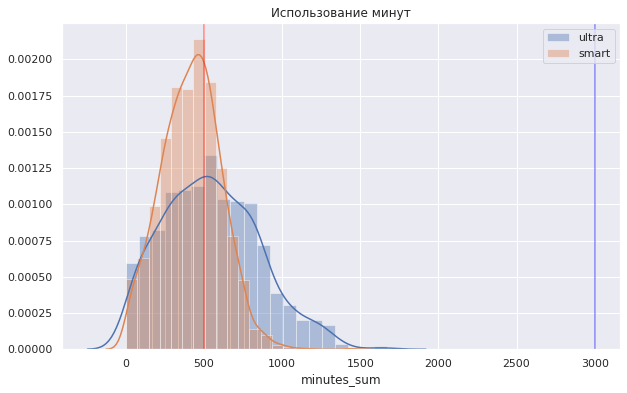

In [62]:
sns.set()
plt.figure(figsize=(10,6))

for tarif in ['ultra', 'smart']:
    data_to_graph = calls_data.query('tariff_name == @tarif')
    ax = dist_hist(data_to_graph, 'minutes_sum', 20, 'Использование минут')
    
#plt.legend(['ultra', 'smart'])
plt.axvline(x=500, color='red', alpha = .45)
plt.axvline(x=3000, color = 'blue', alpha = .45)

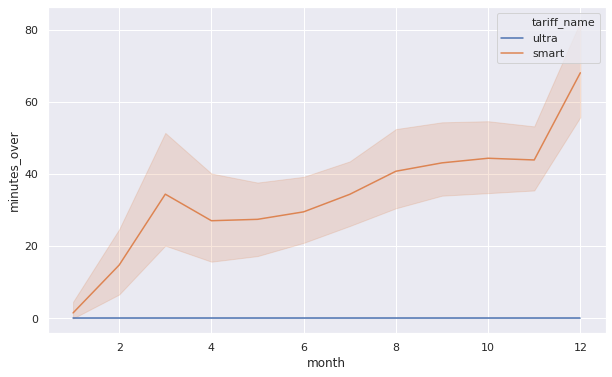

In [63]:
sns.set()
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="month", y="minutes_over", hue="tariff_name",
                  data=calls_data)


In [64]:
pivot_calls1 = pivot_tarifs(calls_data,'minutes_sum', {np.mean,np.median,np.max,np.std})
pivot_calls1

,amax,mean,median,std
tariff_name,,,,
smart,1435.0,419.440342,423.0,188.992403
ultra,1673.0,547.755016,529.0,305.513385


In [65]:
pivot_tarifs(calls_data,'using_calls', {np.mean,np.median,np.max})

,amax,mean,median
tariff_name,,,
smart,2.870000,0.838881,0.846000
ultra,0.557667,0.182585,0.176333


На данном графике четко видно, что пользователи тарифа smart, часто совершают больше звонков, чем им предоставлено изначально в рамках тарифа. Таким образом, мы можем предварительно заключить, что, скорее всего, переплата по тарифу в этой группе больше.

**Важные выводы:**

***1) Расход по минутам в месяц:***

Среднее значения для пользователей тарифа <font color=orange>**smart**</font> - 420 минут, разброс - 189 минут.

Среднее значения для пользователей тарифа <font color=blue>**ultrat**</font> - 529 минут, разброс - 305 минут.

***2) Перерасход по месяцам:***

У пользователей <font color=orange>**smart**</font> перерасход минут держится на стабильном уровне в течение года и возрастает к Новому году. У пользователей <font color=blue>**ultra**</font> перерасхода по звонкам - нет или он не значим по сравнению с другой группой



***3) Использование пакета:***

50% пользователь тарифа <font color=orange>**smart**</font> проговоривают в месяц в среднем 84% от пакета, максимальное превышение пакета в 3 раза.

50% пользователь тарифа <font color=blue>**ultra**</font>  проговоривают в месяц в среднем 18% от пакета, превышений не зафиксировано

### Использование sms-сообщений

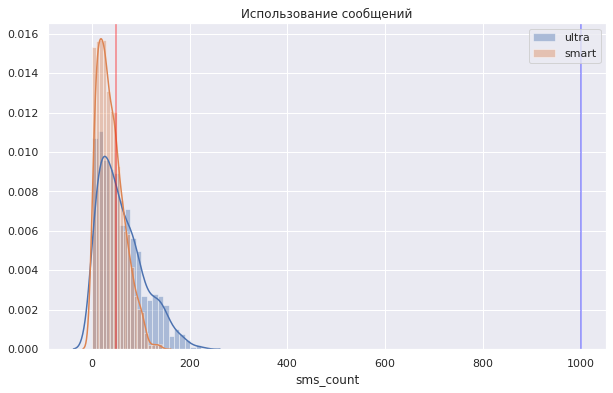

In [66]:
sns.set()
plt.figure(figsize=(10,6))

for tarif in ['ultra', 'smart']:
    data_to_graph = sms_data.query('tariff_name == @tarif')
    ax = dist_hist(data_to_graph, 'sms_count', 20, 'Использование сообщений')
    
plt.legend(['ultra', 'smart'], loc='upper right')
plt.axvline(x=50, color='red', alpha = .45)
plt.axvline(x=1000, color = 'blue', alpha = .45)

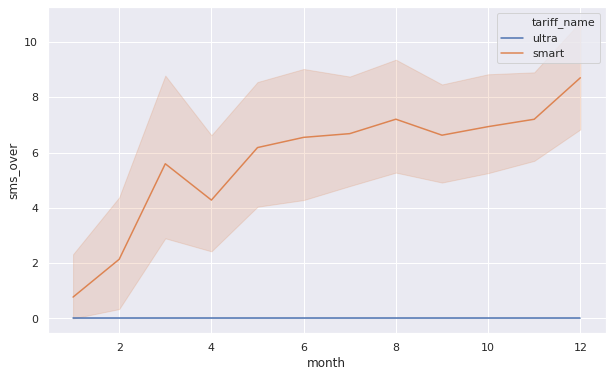

In [67]:
sns.set()
plt.figure(figsize=(10,6))

ax = sns.lineplot(x="month", y="sms_over", hue="tariff_name",
                  data=sms_data)

In [68]:
pivot_sms1 = pivot_tarifs(sms_data,'sms_count', {np.mean,np.median,np.max,np.std})
pivot_sms1

,amax,mean,median,std
tariff_name,,,,
smart,143.0,38.716441,34.0,26.787949
ultra,224.0,61.161006,51.0,45.931026


In [69]:
pivot_tarifs(sms_data,'using_sms', {np.mean,np.median,np.max})

,amax,mean,median
tariff_name,,,
smart,2.860,0.774329,0.680
ultra,0.224,0.061161,0.051


С сообщениями похожая ситуация, у пользователей тарифа `smart` больше шансов переплатить за сообщениями, чем у пользователей другого тарифа (по фигуре понятно).


**Важные выводы:**


***1) Расход по сообщенями в месяц:***

Среднее значения для пользователей тарифа <font color=orange>**smart**</font> - 38 сообщений, разброс - 26 сообщений.

Среднее значения для пользователей тарифа <font color=blue>**ultrat**</font> - 61 сообщений, разброс - 45 сообщений.

***2) Перерасход по месяцам:***

У пользователей <font color=orange>**smart**</font> перерасход сообщений держится на стабильном уровне летом и возрастает к Новому году. У пользователей <font color=blue>**ultra**</font> перерасхода по смскам - нет или он не значим по сравнению с другой группой


***3) Использование пакета:***

50% пользователь тарифа <font color=orange>**smart**</font> отправляют в месяц в среднем 77.5% сообщений от пакета, максимальное превышение пакета почти в 3 раза

50% пользователь тарифа <font color=blue>**ultra**</font> отправляют в месяц в среднем в месяц в среднем 6% от пакета, превышений не было

### Использование интернета

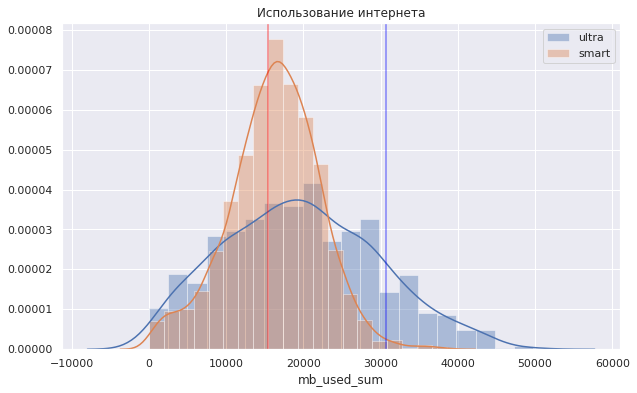

In [70]:
sns.set()
plt.figure(figsize=(10,6))
for tarif in ['ultra', 'smart']:
    data_to_graph = internet_data.query('tariff_name == @tarif')
    ax = dist_hist(data_to_graph, 'mb_used_sum', 20, 'Использование интернета')
    

plt.axvline(x=15360, color='red', alpha = .45)
plt.axvline(x=30720, color = 'blue', alpha = .45)

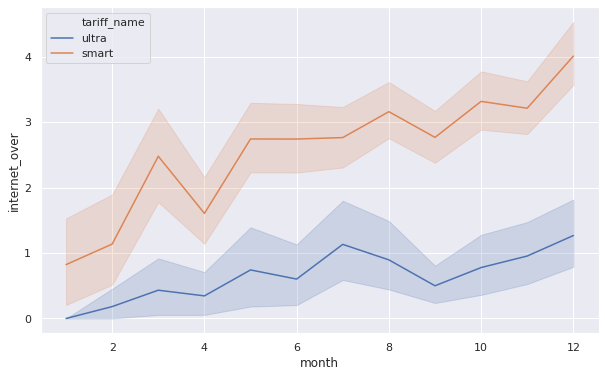

In [71]:
sns.set()
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="month", y="internet_over", hue="tariff_name",
                  data=internet_data)

In [72]:
pivot_int1 = pivot_tarifs(internet_data,'mb_used_sum', {np.mean,np.median,np.max,np.std})
pivot_int1

,amax,mean,median,std
tariff_name,,,,
smart,38553.0,16216.148564,16508.0,5861.741292
ultra,49746.0,19668.993846,19395.0,9943.067706


In [73]:
pivot_tarifs(internet_data,'using_internet', {np.mean,np.median,np.max})

,amax,mean,median
tariff_name,,,
smart,2.509961,1.055739,1.074740
ultra,1.619336,0.640267,0.631348


Для интернета получился самый интересный график - если для звонков и сообщений только пользователи тарифа smart выходили за пределы пакета, то теперь и абоненты с более дорогостоящим тарифов смогли вырваться за пределы пакета. Причем пользователи тарифа `ultra` более вариативны в своем использовании интернета (график пологий)


**Важные выводы:**


***1) Расход по гигабайтам в месяц:***

Среднее значения для пользователей тарифа <font color=orange>**smart**</font> - 16 gb интернета, разброс - 5.8 gb.

Среднее значения для пользователей тарифа <font color=blue>**ultra**</font> - 20 gb интернет трафика, разброс - 10 gb.


***2) Перерасход по месяцам:***

Чаще всего всего перерасход происходит в месяцы, когда происходят значимые праздники (конец февраля, начало марта), а также под Новый год.

***3) Использование пакета:***

50% пользователь тарифа <font color=orange>**smart**</font> используют в месяц в среднем 105% от пакета интернета, максимальное превышение пакета в 2.5 раза

50% пользователь тарифа <font color=blue>**ultra**</font> используют в месяц в среднем 64% от пакета интернета, максимальное превышение пакета в 1.6 раз




### Как можно оптимизировать тарифы

Посчитаем сколько потребуются пользователям разных тарифов пакетных услуг (минут, смс, интернет-трафика), чтобы удовлетворить 95% пользователей тарифа. Для этого применим правило 3-х сигм

In [74]:
profile_real = pivot_int1.merge(pivot_calls1[['mean','std']],
                                on='tariff_name').merge(pivot_sms1[['mean','std']],
                                                        on='tariff_name')
profile_real.drop(['amax','median',],axis = 1, inplace=True)
profile_real.columns=['mean_int','std_int','mean_minute','std_minute','sms_mean','std_min']
#profile_real = profile_real.astype(int)
profile_real

,mean_int,std_int,mean_minute,std_minute,sms_mean,std_min
tariff_name,,,,,,
smart,16216.148564,5861.741292,419.440342,188.992403,38.716441,26.787949
ultra,19668.993846,9943.067706,547.755016,305.513385,61.161006,45.931026


In [75]:
cols = ['expected_internet','expected_minutes','expected_sms']
a=0
b=1
for col in cols:
    profile_real[col] = profile_real.iloc[:,a] + 2*profile_real.iloc[:,b]
    a+=2
    b+=2
    
profile_real.drop(profile_real.columns[[0,1,2,3,4,5]], axis='columns', inplace=True)
profile_real

,expected_internet,expected_minutes,expected_sms
tariff_name,,,
smart,27939.631147,797.425149,92.292339
ultra,39555.129258,1158.781785,153.023059


***Придадим таблице надлежащий вид и округлим значения. Мегабайт в целые гигабайты, минуты по сотням, смс тоже по сотням:***

In [76]:
profile_real['expected_internet'] = profile_real['expected_internet'].apply(lambda x: (x//1024) + 1).astype(int)
profile_real['expected_minutes'] = profile_real['expected_minutes'].apply(lambda x: ((x//100) + 1)*100 ).astype(int)
profile_real['expected_sms'] = profile_real['expected_sms'].apply(lambda x: ((x//100) + 1)*100 ).astype(int)
profile_real

,expected_internet,expected_minutes,expected_sms
tariff_name,,,
smart,28,800,100
ultra,39,1200,200


Таким образом, мы получили таблицу ожидаемых значений, чтобы покрыть потребности 95% клиентов. 28 гигабайт, 800 минут, 100 - для дешевого тарифа. Это похоже на тариф мечты.

Взглянем ещё раз на текущие тарифы:

In [77]:
tarifs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Сравнивая эти две таблицы, можно заметить разницу между ожиданиями компании и запросами пользователей.

**Звонки и смс-ки актуальны или уже нет?**

В 2018 году огромное количество включенных в тариф смс и минут - уже не является таким актуальным предложением. По сути пользователи разных тарифов сдвинулись в сторону друг друга в этих показателях. Разница между группами по их ожидаемым значениям не является такой существенной, как заявлено в тарифе. Например, отношение минут в тарифах - 1/6, а по ожидаемым значениям - 3/6. Причем, пользователи тарифа Ultra не превышают расхода тарифа по этим предложениям (40% для звонков и 20% для смс-сообщений)

**Всем нужен интернет**

По показателю интернета обе группы сошлись во мнении, что им нужно больше интернет трафика. Для пользователей Смарт'а почти в 2 раза, для пользователей Ultra в 1,5 раза

Таким образом, можно заключить, что компании стоит работать над выгодными предложениями по интернет-пакетам, чтобы сильнее заинтересовать пользователей в своих услугах.

Побочным результатом стоит рассмотреть введение промежуточного тарифа между Smart и Ultra

### Анализ по абонентам

Настало пора считать доход или revenue от каждого пользователя для компаниия. В каждой из баз уже посчитан доход от услуг сверх пакета, В связи с тем, что количество записей различается, то придется прибавить к каждой таблице количество месяцев с данными по использованию, а потому уже вычислять сумму абонентский плат


In [78]:
def revenue(row):
    tariff = row['tariff_name']
    num = row['profit']
    if tariff == 'smart':
        return num+550
    else:
        return num+1950

In [79]:
internet_data.sort_values(by='user_id', ascending = True).head()

,user_id,month,session_count,mb_used_sum,tariff_name,mb_per_month_included,rub_per_gb,using_internet,internet_over,profit
0,1000,5,5,2254,ultra,30720,150,0.073372,0,0
1,1000,6,49,23234,ultra,30720,150,0.756315,0,0
2,1000,7,29,14004,ultra,30720,150,0.455859,0,0
3,1000,8,29,14056,ultra,30720,150,0.457552,0,0
4,1000,9,27,14569,ultra,30720,150,0.474251,0,0


In [80]:
temp = internet_data.merge(
        calls_data[['user_id','month','minutes_sum','using_calls','profit']], on= ['user_id','month'], how = 'outer')                         
temp = temp.merge(sms_data[['user_id','month','sms_count','using_sms','profit']],on= ['user_id','month'],how='outer')

# Что же у нас получилось...
temp

,user_id,month,session_count,mb_used_sum,tariff_name,mb_per_month_included,rub_per_gb,using_internet,internet_over,profit_x,minutes_sum,using_calls,profit_y,sms_count,using_sms,profit
0,1000,5,5.0,2254.0,ultra,30720.0,150.0,0.073372,0.0,0.0,159.0,0.053000,0.0,22.0,0.022,0.0
1,1000,6,49.0,23234.0,ultra,30720.0,150.0,0.756315,0.0,0.0,172.0,0.057333,0.0,60.0,0.060,0.0
2,1000,7,29.0,14004.0,ultra,30720.0,150.0,0.455859,0.0,0.0,340.0,0.113333,0.0,75.0,0.075,0.0
3,1000,8,29.0,14056.0,ultra,30720.0,150.0,0.457552,0.0,0.0,408.0,0.136000,0.0,81.0,0.081,0.0
4,1000,9,27.0,14569.0,ultra,30720.0,150.0,0.474251,0.0,0.0,466.0,0.155333,0.0,57.0,0.057,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1273,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,272.0,0.090667,0.0,29.0,0.029,0.0
3210,1273,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260.0,0.086667,0.0,39.0,0.039,0.0
3211,1377,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.0,0.059667,0.0,2.0,0.002,0.0
3212,1392,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,0.004333,0.0,3.0,0.003,0.0


In [81]:
users_monthly_revenue = users.merge(temp[['user_id','month',\
                                         'minutes_sum','using_calls','profit_x',\
                                        'mb_used_sum','using_internet','profit_y',\
                                        'sms_count','using_sms','profit']], on='user_id', how='right')
users_monthly_revenue

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_sum,using_calls,profit_x,mb_used_sum,using_internet,profit_y,sms_count,using_sms,profit
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,159.0,0.053000,0.0,2254.0,0.073372,0.0,22.0,0.022,0.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,172.0,0.057333,0.0,23234.0,0.756315,0.0,60.0,0.060,0.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,340.0,0.113333,0.0,14004.0,0.455859,0.0,75.0,0.075,0.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,408.0,0.136000,0.0,14056.0,0.457552,0.0,81.0,0.081,0.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,466.0,0.155333,0.0,14569.0,0.474251,0.0,57.0,0.057,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10,247.0,0.494000,1200.0,20580.0,1.339844,0.0,42.0,0.840,0.0
3210,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,9,70.0,0.140000,0.0,1846.0,0.120182,0.0,11.0,0.220,0.0
3211,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,10,449.0,0.898000,600.0,17789.0,1.158138,0.0,48.0,0.960,0.0
3212,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,11,612.0,1.224000,600.0,17964.0,1.169531,336.0,59.0,1.180,27.0


Проверим себя по дубликатам

In [82]:
users_monthly_revenue.drop_duplicates(subset=['user_id','month'], inplace=True)

In [83]:
len(users_monthly_revenue['user_id'].unique())

498

In [84]:
users_monthly_revenue.shape

(3214, 18)

Слияние прошло успешно и было сделано правильно

**Целостной таблицы по id не нарушена, удалим ненужные столбцы:**

In [85]:
users_monthly_revenue.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_sum,using_calls,profit_x,mb_used_sum,using_internet,profit_y,sms_count,using_sms,profit
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,159.0,0.053000,0.0,2254.0,0.073372,0.0,22.0,0.022,0.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,172.0,0.057333,0.0,23234.0,0.756315,0.0,60.0,0.060,0.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,340.0,0.113333,0.0,14004.0,0.455859,0.0,75.0,0.075,0.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,408.0,0.136000,0.0,14056.0,0.457552,0.0,81.0,0.081,0.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,466.0,0.155333,0.0,14569.0,0.474251,0.0,57.0,0.057,0.0


In [86]:
users_monthly_revenue.isnull().sum()

user_id              0
age                  0
churn_date        3027
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
month                0
minutes_sum         46
using_calls         46
profit_x            11
mb_used_sum         11
using_internet      11
profit_y            46
sms_count          497
using_sms          497
profit             497
dtype: int64

In [87]:
users_monthly_revenue = users_monthly_revenue.drop(columns=['churn_date','first_name','last_name','reg_date'])

In [88]:
users_monthly_revenue = users_monthly_revenue.fillna(0)

In [89]:
users_monthly_revenue.isnull().sum()

user_id           0
age               0
city              0
tariff            0
month             0
minutes_sum       0
using_calls       0
profit_x          0
mb_used_sum       0
using_internet    0
profit_y          0
sms_count         0
using_sms         0
profit            0
dtype: int64

**Теперь можно посчитать общий доход:**

In [90]:

# создаем в новый столбец в который добавляем абонентскую плату
users_monthly_revenue['revenue_per_month'] = \
users_monthly_revenue['tariff'].apply(lambda x: 550 if x == 'smart' else 1950)


In [91]:
# теперь прибавляем тарификацию сверх
users_monthly_revenue['revenue_per_month'] = \
(users_monthly_revenue['revenue_per_month'] + users_monthly_revenue['profit'] + \
users_monthly_revenue['profit_x'] + \
users_monthly_revenue['profit_y'])

In [92]:
users_monthly_revenue.head()

,user_id,age,city,tariff,month,minutes_sum,using_calls,profit_x,mb_used_sum,using_internet,profit_y,sms_count,using_sms,profit,revenue_per_month
0,1000,52,Краснодар,ultra,5,159.0,0.053000,0.0,2254.0,0.073372,0.0,22.0,0.022,0.0,1950.0
1,1000,52,Краснодар,ultra,6,172.0,0.057333,0.0,23234.0,0.756315,0.0,60.0,0.060,0.0,1950.0
2,1000,52,Краснодар,ultra,7,340.0,0.113333,0.0,14004.0,0.455859,0.0,75.0,0.075,0.0,1950.0
3,1000,52,Краснодар,ultra,8,408.0,0.136000,0.0,14056.0,0.457552,0.0,81.0,0.081,0.0,1950.0
4,1000,52,Краснодар,ultra,9,466.0,0.155333,0.0,14569.0,0.474251,0.0,57.0,0.057,0.0,1950.0


Построим сводную таблицу и график по месяцам:

In [93]:
pivot_m_revenue = users_monthly_revenue.pivot_table(index=['tariff','month'],\
                                                    values='revenue_per_month', aggfunc = {'sum','median','mean'})
pivot_m_revenue

mean  median       sum
tariff month                               
smart  1       721.323529   550.0   24525.0
       2       827.603448   550.0   48001.0
       3      1164.623377   886.0   89676.0
       4       963.089286   620.5  107866.0
       5      1197.510638   986.0  168849.0
       6      1204.018293   950.0  197459.0
       7      1223.950249   981.0  246014.0
       8      1320.595745  1079.0  310340.0
       9      1249.946154   958.5  324986.0
       10     1364.853741  1150.0  401267.0
       11     1343.047468  1150.0  424403.0
       12     1578.531157  1277.0  531965.0
ultra  1      1950.000000  1950.0   17550.0
       2      1975.000000  1950.0   47400.0
       3      2014.864865  1950.0   74550.0
       4      2001.818182  1950.0  110100.0
       5      2059.701493  1950.0  138000.0
       6      2039.285714  1950.0  171300.0
       7      2118.131868  1950.0  192750.0
       8      2083.177570  1950.0  222900.0
       9      2024.347826  1950.0  232800.0
       10     2065.853659  1950.0  254100.0
       11     2092.164179  1950.0  280350.0
       12     2138.848921  1950.0  297300.0

In [94]:
line_data = pivot_m_revenue.reset_index()
line_data

,tariff,month,mean,median,sum
0,smart,1,721.323529,550.0,24525.0
1,smart,2,827.603448,550.0,48001.0
2,smart,3,1164.623377,886.0,89676.0
3,smart,4,963.089286,620.5,107866.0
4,smart,5,1197.510638,986.0,168849.0
5,smart,6,1204.018293,950.0,197459.0
6,smart,7,1223.950249,981.0,246014.0
7,smart,8,1320.595745,1079.0,310340.0
8,smart,9,1249.946154,958.5,324986.0
9,smart,10,1364.853741,1150.0,401267.0


In [95]:
def periodic_graph(data, col, limit):
    sns.set()
    plt.figure(figsize=(10,8))
    if limit == True:
        plt.ylim(0, 3000)
        plt.axhline(550, color='blue')
        plt.axhline(1950, color='red')
        
    ax = sns.lineplot(x="month", y= col,\
                      hue="tariff",sizes=(.25, 2.5), data=data[['tariff','month', col]])

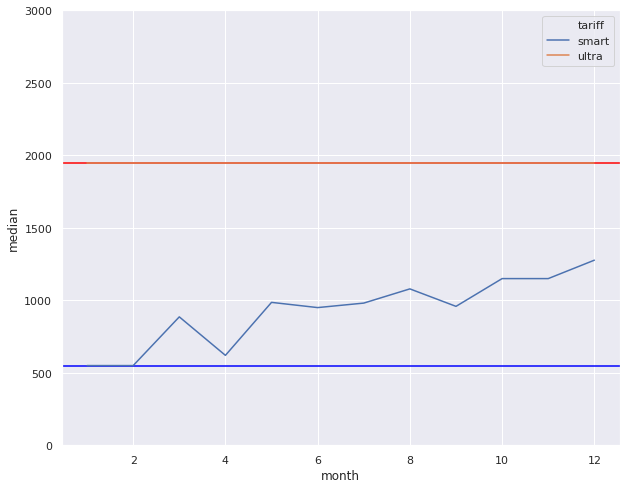

In [96]:
periodic_graph(line_data, 'median', True)

1) Медианная выручка у пользователей тарифа smart возрастает скачкообразно в месяцы, где идут активные праздники(мартовские, майские, новый год) и наступает лето. Да и в целом, 50% регулярно переплачивают в течение года.

2) 50% smart'a платит больше 1200 рублей в месяц в предновогодний период, что является превышением тарифа в 2 раза.

3) Медианная выручка у пользователей тарифа Ультра (они совпали с линией тарифа)

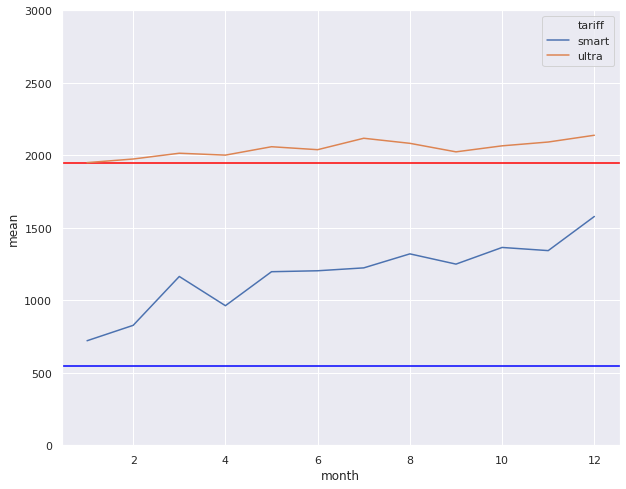

In [97]:
periodic_graph(line_data, 'mean', True)

1) Аналогично - средняя выручка у пользователей тарифа smart возрастает скачкообразно в месяцы, где идут активные праздники(мартовские, майские, новый год) и наступает лето. Да и в целом, 50% регулярно переплачивают в течение года.

2) Среднее значение расходов  в предновогодний период - 1500, что является превышением тарифа почти в 3 раза.

3) Среднее значение расходов у пользователей тарифа Ультра почти совпадает с линией абонентской платы, однако повышение происходит летом и в предновогодний период

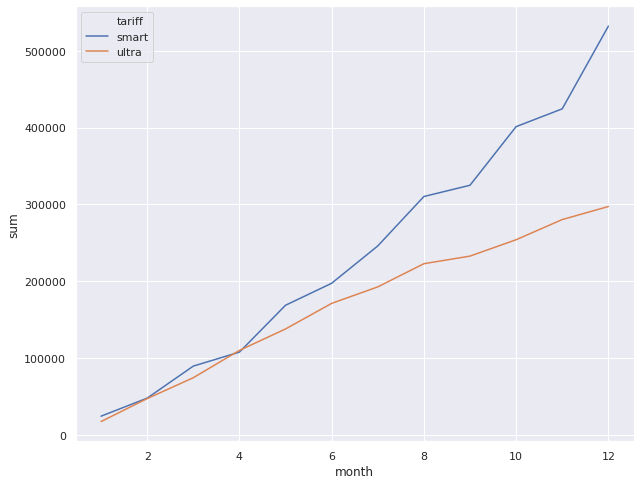

In [98]:
ax = periodic_graph(line_data, 'sum', False)

1) В начале годовая суммарная выручка по тарифам почти совпадает, однако к концу года она изменилась в сторону того, что пользователи тарифа smart, переплачивая за сверх-трафик, дает гораздо больше выручки, чем абоненты с другим тарифом

2) "Примерный" паритет между тарифам был достигнут в феврале и апреле

***Отсюда следует, что из-за массовости и переплат, абоненты с тарифом smart приносят компании больше денег, чем абонент с более дорогим тарифом***

### Старая таблица:

In [99]:
def groupy(data,gr_cols, col, functions):
    groupy = data.groupby(gr_cols)[col].agg(functions)
    return groupy

In [100]:
calls_data.head()

,user_id,month,calls_count,minutes_sum,tariff_name,minutes_included,rub_per_minute,using_calls,minutes_over,profit
0,1000,5,17,159,ultra,3000,1,0.053000,0,0
1,1000,6,28,172,ultra,3000,1,0.057333,0,0
2,1000,7,41,340,ultra,3000,1,0.113333,0,0
3,1000,8,42,408,ultra,3000,1,0.136000,0,0
4,1000,9,46,466,ultra,3000,1,0.155333,0,0


**Агрегируем данные по звонкам:**

In [101]:
calls_gr = groupy(calls_data,'user_id', 'profit', {'count','sum','mean'})
calls_gr.head()

,count,mean,sum
user_id,,,
1000,8,0.0,0
1001,2,0.0,0
1002,7,0.0,0
1003,5,0.0,0
1004,8,0.0,0


In [102]:
internet_gr = groupy(internet_data,'user_id', 'profit', {'count','sum','mean'})
internet_gr.head()

,count,mean,sum
user_id,,,
1000,8,0.000000,0
1001,2,300.000000,600
1002,7,485.714286,3400
1003,5,0.000000,0
1004,8,0.000000,0


In [103]:
sms_gr = groupy(sms_data,'user_id' ,'profit', {'count','sum','mean'})
sms_gr.head()

,count,mean,sum
user_id,,,
1000,8,0.00,0
1002,7,0.00,0
1003,5,0.00,0
1004,8,0.00,0
1005,12,8.25,99


**Теперь будем "джойнить" в новый фрейм по пользователям:**

In [104]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [149]:
users_profit = users.merge(internet_gr,\
                           on='user_id',how='left', suffixes=('', '_internet')).merge(calls_gr,\
                           on='user_id',how='left', suffixes=('', '_calls')).merge(sms_gr,\
                           on='user_id',how='left', suffixes=('', '_sms'))
#users_profit.drop(columns='month',inplace=True)
users_profit.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,count,mean,sum,count_calls,mean_calls,sum_calls,count_sms,mean_sms,sum_sms
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,0.0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,2.0,300.000000,600.0,2.0,0.0,0.0,NaN,NaN,NaN
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,7.0,485.714286,3400.0,7.0,0.0,0.0,7.0,0.0,0.0
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,5.0,0.000000,0.0,5.0,0.0,0.0,5.0,0.0,0.0
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,0.0


In [150]:
users_profit[users_profit['mean'].isnull() == True]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,count,mean,sum,count_calls,mean_calls,sum_calls,count_sms,mean_sms,sum_sms
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,1273,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,NaN,NaN,NaN,8.0,0.0,0.0,8.0,0.0,0.0
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Вот и обнаружились аномалии, о которых мы не забыли. Из-за того, что предыдущие действия были выполнены в данном стиле и был применен left join, то мы получили `user_id` 2 пользователей, кто пробыл с нашей компанией меньше месяца, и ещё один идентификатор пользователя, который не пользуется интернетом.

Итак, ***обработка для получения "чистого дохода" с пользователя сводится к следующему***:

1) Сделать дроп для 2 пользователей без данных

2) Очистить от абонентской платы остальные значения и просуммировать их

In [151]:
users_profit.drop(index=[128, 371], inplace=True)

#Ну и нам не нужны личные имена пользователей - пусть будут анонимными
users_profit.drop(columns=['first_name','last_name'], inplace=True)

In [152]:
users_profit[users_profit['mean'].isnull() == True]

,user_id,age,churn_date,city,reg_date,tariff,count,mean,sum,count_calls,mean_calls,sum_calls,count_sms,mean_sms,sum_sms
273,1273,46,NaT,Курган,2018-05-15,ultra,NaN,NaN,NaN,8.0,0.0,0.0,8.0,0.0,0.0


**Дроп успешен. Переходим к следующему шагу:**

In [153]:
users_profit.columns

Index(['user_id', 'age', 'churn_date', 'city', 'reg_date', 'tariff', 'count',
       'mean', 'sum', 'count_calls', 'mean_calls', 'sum_calls', 'count_sms',
       'mean_sms', 'sum_sms'],
      dtype='object')

In [154]:
users_profit.columns = ['user_id','age','churn_date','city','reg_date',\
                        'tariff','internet_m','internet_mean',\
                        'internet_total','calls_m','calls_mean','calls_total',\
                        'sms_m','sms_mean','sms_total']

In [155]:
users_profit.head()

,user_id,age,churn_date,city,reg_date,tariff,internet_m,internet_mean,internet_total,calls_m,calls_mean,calls_total,sms_m,sms_mean,sms_total
0,1000,52,NaT,Краснодар,2018-05-25,ultra,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,0.0
1,1001,41,NaT,Москва,2018-11-01,smart,2.0,300.000000,600.0,2.0,0.0,0.0,NaN,NaN,NaN
2,1002,59,NaT,Стерлитамак,2018-06-17,smart,7.0,485.714286,3400.0,7.0,0.0,0.0,7.0,0.0,0.0
3,1003,23,NaT,Москва,2018-08-17,ultra,5.0,0.000000,0.0,5.0,0.0,0.0,5.0,0.0,0.0
4,1004,68,NaT,Новокузнецк,2018-05-14,ultra,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,0.0


In [156]:

users_profit.iloc[:,5:] = users_profit.iloc[:,5:].fillna(0)
users_profit.head()

,user_id,age,churn_date,city,reg_date,tariff,internet_m,internet_mean,internet_total,calls_m,calls_mean,calls_total,sms_m,sms_mean,sms_total
0,1000,52,NaT,Краснодар,2018-05-25,ultra,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,0.0
1,1001,41,NaT,Москва,2018-11-01,smart,2.0,300.000000,600.0,2.0,0.0,0.0,0.0,0.0,0.0
2,1002,59,NaT,Стерлитамак,2018-06-17,smart,7.0,485.714286,3400.0,7.0,0.0,0.0,7.0,0.0,0.0
3,1003,23,NaT,Москва,2018-08-17,ultra,5.0,0.000000,0.0,5.0,0.0,0.0,5.0,0.0,0.0
4,1004,68,NaT,Новокузнецк,2018-05-14,ultra,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,0.0


Напишем функцию для вычисления платы по тарифу:

In [157]:
def core_revenue(row):
    tariff = row['tariff']
    num1 = row['internet_m']
    num2 = row['calls_m']
    num3 = row['sms_m']
    num = max(num1,max(num2,num3))
    if tariff == 'smart':
        return num*550
    else:
        return num*1950

In [158]:
users_profit['annual_fee_revenue'] = users_profit.apply(core_revenue,axis=1)

In [159]:
users_profit.head()

,user_id,age,churn_date,city,reg_date,tariff,internet_m,internet_mean,internet_total,calls_m,calls_mean,calls_total,sms_m,sms_mean,sms_total,annual_fee_revenue
0,1000,52,NaT,Краснодар,2018-05-25,ultra,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,0.0,15600.0
1,1001,41,NaT,Москва,2018-11-01,smart,2.0,300.000000,600.0,2.0,0.0,0.0,0.0,0.0,0.0,1100.0
2,1002,59,NaT,Стерлитамак,2018-06-17,smart,7.0,485.714286,3400.0,7.0,0.0,0.0,7.0,0.0,0.0,3850.0
3,1003,23,NaT,Москва,2018-08-17,ultra,5.0,0.000000,0.0,5.0,0.0,0.0,5.0,0.0,0.0,9750.0
4,1004,68,NaT,Новокузнецк,2018-05-14,ultra,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,0.0,15600.0


In [160]:
users_profit['total_revenue'] = users_profit[['internet_total','calls_total','sms_total','annual_fee_revenue']].apply(np.sum, axis=1)

In [161]:
users_profit['over_total'] = users_profit[['internet_total','calls_total','sms_total']].apply(np.sum, axis=1)

In [162]:
users_profit['over_monthly'] = users_profit[['internet_mean','calls_mean','sms_mean']].apply(np.sum, axis=1)

In [163]:
users_profit.head()

,user_id,age,churn_date,city,reg_date,tariff,internet_m,internet_mean,internet_total,calls_m,calls_mean,calls_total,sms_m,sms_mean,sms_total,annual_fee_revenue,total_revenue,over_total,over_monthly
0,1000,52,NaT,Краснодар,2018-05-25,ultra,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,0.0,15600.0,15600.0,0.0,0.000000
1,1001,41,NaT,Москва,2018-11-01,smart,2.0,300.000000,600.0,2.0,0.0,0.0,0.0,0.0,0.0,1100.0,1700.0,600.0,300.000000
2,1002,59,NaT,Стерлитамак,2018-06-17,smart,7.0,485.714286,3400.0,7.0,0.0,0.0,7.0,0.0,0.0,3850.0,7250.0,3400.0,485.714286
3,1003,23,NaT,Москва,2018-08-17,ultra,5.0,0.000000,0.0,5.0,0.0,0.0,5.0,0.0,0.0,9750.0,9750.0,0.0,0.000000
4,1004,68,NaT,Новокузнецк,2018-05-14,ultra,8.0,0.000000,0.0,8.0,0.0,0.0,8.0,0.0,0.0,15600.0,15600.0,0.0,0.000000


In [164]:
def monthly_mean(row):
    a=row['over_monthly']
    b= row['tariff']
    if b == 'smart':
        return a+ 550
    else: return a+1950

In [165]:
users_profit['monthly_paid'] = users_profit.apply(monthly_mean, axis=1)
users_profit.head(20)

,user_id,age,churn_date,city,reg_date,tariff,internet_m,internet_mean,internet_total,calls_m,calls_mean,calls_total,sms_m,sms_mean,sms_total,annual_fee_revenue,total_revenue,over_total,over_monthly,monthly_paid
0,1000,52,NaT,Краснодар,2018-05-25,ultra,8.0,0.000000,0.0,8.0,0.000000,0.0,8.0,0.000000,0.0,15600.0,15600.0,0.0,0.000000,1950.000000
1,1001,41,NaT,Москва,2018-11-01,smart,2.0,300.000000,600.0,2.0,0.000000,0.0,0.0,0.000000,0.0,1100.0,1700.0,600.0,300.000000,850.000000
2,1002,59,NaT,Стерлитамак,2018-06-17,smart,7.0,485.714286,3400.0,7.0,0.000000,0.0,7.0,0.000000,0.0,3850.0,7250.0,3400.0,485.714286,1035.714286
3,1003,23,NaT,Москва,2018-08-17,ultra,5.0,0.000000,0.0,5.0,0.000000,0.0,5.0,0.000000,0.0,9750.0,9750.0,0.0,0.000000,1950.000000
4,1004,68,NaT,Новокузнецк,2018-05-14,ultra,8.0,0.000000,0.0,8.0,0.000000,0.0,8.0,0.000000,0.0,15600.0,15600.0,0.0,0.000000,1950.000000
5,1005,67,NaT,Набережные Челны,2018-01-25,smart,12.0,0.000000,0.0,12.0,268.750000,3225.0,12.0,8.250000,99.0,6600.0,9924.0,3324.0,277.000000,827.000000
6,1006,21,NaT,Ульяновск,2018-02-26,smart,11.0,381.818182,4200.0,11.0,0.000000,0.0,0.0,0.000000,0.0,6050.0,10250.0,4200.0,381.818182,931.818182
7,1007,65,NaT,Москва,2018-04-19,smart,9.0,244.444444,2200.0,9.0,119.000000,1071.0,9.0,0.000000,0.0,4950.0,8221.0,3271.0,363.444444,913.444444
8,1008,63,NaT,Челябинск,2018-12-19,smart,1.0,0.000000,0.0,1.0,0.000000,0.0,1.0,18.000000,18.0,550.0,568.0,18.0,18.000000,568.000000
9,1009,24,NaT,Пермь,2018-03-22,smart,10.0,760.000000,7600.0,10.0,0.000000,0.0,10.0,0.000000,0.0,5500.0,13100.0,7600.0,760.000000,1310.000000


#### Дополнительные сведения:

Посмотрим на средний и медианный возраст у абонентов разных тарифов:

In [166]:
users_profit.pivot_table(index='tariff', values='age', aggfunc={'mean','median'})

,mean,median
tariff,,
smart,46.445714,46.5
ultra,46.871622,46.0


Интересно, пользователи практически не отличаются по среднему значению и медиане возраста. Получается, что тарифы нацелены на широкую аудиторию и не имеют специализации (звонки - для более зрелой, интернет для молодежи), что в принципе логично

In [167]:
revenue_annual = np.sum(users_profit['total_revenue'])
revenue_annual

4914451.0

In [168]:
revenue_table = users_profit.pivot_table(index='tariff', values='total_revenue', aggfunc={'sum'})


In [169]:
revenue_table['percentage'] = (revenue_table['sum'] / revenue_annual)*100
revenue_table['sum'] = revenue_table['sum']/ 1000000
revenue_table.columns= ['Выручка за год, млн. рублей','%']

In [170]:
revenue_table

,"Выручка за год, млн. рублей",%
tariff,,
smart,2.875351,58.508082
ultra,2.039100,41.491918


По данной таблице можно заключить, что из-за своей массовости в выборке годовая выручка по тарифу Smart оказалась намного больше, чем по тарифу Ultra. Необходимо уточнить насколько выборка повторяет генеральную совокупность всех абонентов компании "Мегалайн" по своей структуре.

Итак, у нас имеются все необходимые данные, чтобы проверить статистическую значимость прибыли от абонентов каждого из тарифа

### Статистический анализ данных


Сформулируем гипотезу о равенстве средних двух генеральных совокупностей и проверим её с помощью статистического теста:

**H0: Среднемесячные выручки от абонентов двух тарифов равны**

**H1: Среднемесячные выручки от абонентов двух тарифов - различны**

Уровень значимости - 0.05, дисперсии не считаем равными

In [171]:
from scipy import stats as st

In [172]:
sample_1 = users_profit.query('tariff == "smart"')['monthly_paid']
sample_2 = users_profit.query('tariff == "ultra"')['monthly_paid']



In [173]:
var_1 = np.var(sample_1)
var_2 = np.var(sample_2)

print(f'''Дисперсия среди пользователей тарифа smart: {var_1}
Дисперсия среди пользователей тарифа ultra: {var_2}
Отношение между дисперсиями: {var_1/var_2}''')

Дисперсия среди пользователей тарифа smart: 366089.5372247031
Дисперсия среди пользователей тарифа ultra: 88519.61075863424
Отношение между дисперсиями: 4.135688511135874


Дисперсия среди пользователей тарифа smart в 4 раза превышает дисперсию среди пользователей тарифа ultra.

**Отсюда мы ставим в параметры теста на равенство средних двух ГС, что дисперсии отличаются**

In [174]:
alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha :
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.180629468847829e-59
Отвергаем нулевую гипотезу


**P-значение получилось слишком маленьким - 2x10^(-59). Совершенно точно можно сказать, что средняя выручка с абонентов различных тарифов отличается.**

А если посчитать на выборке, то какой результат мы получим?

In [175]:
smart_mean = np.mean(sample_1)
ultra_mean = np.mean(sample_2)

print('''Среднемесячная выручка за абонентов тарифа smart: {}
Среднемесячная выручка за абонентов тарифа ultra: {}'''.format(smart_mean, ultra_mean))

Среднемесячная выручка за абонентов тарифа smart: 1324.6581621315192
Среднемесячная выручка за абонентов тарифа ultra: 2086.4646586521585


In [176]:
print('Среднемесячная выручка за переплату абонентов тарифа smart: {}\n\
Среднемесячная выручка за переплату абонентов тарифа ultra: {}'.format(ultra_mean-1950, smart_mean-550))

Среднемесячная выручка за переплату абонентов тарифа smart: 136.4646586521585
Среднемесячная выручка за переплату абонентов тарифа ultra: 774.6581621315192


Таким образом, мы убедились, что несмотря на переплату, абоненты с тарифом smart приносят компании меньше денег в среднем за человека, чем абоненты более дорогостоящего ultra

Теперь сравним среднее значение выручки на абонента из Москвы и других городов:

**H0: Среднемесячная выручка в Москве и других городах совпадают**

**H1: Среднемесячная выручка в Москве и других городах отличается**

Уровень значимости - 0.05, дисперсии не считаем равными

In [177]:
sample_3 = users_profit.query('city == "Москва"')['monthly_paid']
sample_4 = users_profit.query('city != "Москва"')['monthly_paid']

alpha = .05 # стандарт для эконометрики

results2 = st.ttest_ind(
    sample_3, 
    sample_4)

print('p-значение:', results2.pvalue)

if results2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3591817925856451
Не получилось отвергнуть нулевую гипотезу


Не удалось отвергнуть нулевую гипотезу - по имеющейся выборке мы не можем заключить, что пользователи Москвы не так сильно отличаются от пользователей в других городах

In [178]:
moscow_mean = np.mean(sample_3)
cities_mean = np.mean(sample_4)

print('Среднемесячная выручка от абонентов из Москвы: {}\nСреднемесячная выручка от абонентов из других городов: {}'.format(moscow_mean, cities_mean))

Среднемесячная выручка от абонентов из Москвы: 1498.465851152215
Среднемесячная выручка от абонентов из других городов: 1564.1077868733885


**Средние значения соотносимы между собой, понятно почему статистический тест показал такой результат**

А что с объемом выборок?

In [179]:
print('Объем выборки абонентов Москвы: {}'.format(len(sample_3)))
print('Объем выборки абонентов из других городов: {}'.format(len(sample_4)))

Объем выборки абонентов Москвы: 99
Объем выборки абонентов из других городов: 399


**Группы между собой отличаются в 4 раза, что примерно соотносимо с рассеиванием населения в России по городам**

## Результаты

Нами был проведен анализ абонентов по имеющейся в базе выборке абонентов разных тарифов применительно к данным об использовании ими интернета, звонков, пакетов. Построили визуализации имеющихся данных, сводные таблицы.

**В ходе анализа мы выяснили следующее:**

- Пользователи тарифа ultra в среднем за месяц не используют свой пакет полностью, меньше всего расход идет по смс-сообщениям (в среднем 6%), больше всего по интернет-трафику (64%). 

- Пользователи тарифа smart в среднем за месяц почти гарантированно покупают дополнительный интернет-трафик(Срелний перерасход - 5%), а также могут оплачивают звонки вне пакета (хотя средний расход пакета - 84%), смс-сообщения. По последним двум практически гарантировано абоненты не добираются до лимита

- Абоненты разных тарифов не имеют кардинальных значений по возрасту

- Для компании лучше 

- Проверили стастический тест на равенство среднемесячных выручек от абонентов разных тарифов (<font color=red>**отрицательно**</font>) и абонентов Москвы и других городов (<font color=green>**положительно**</font>). Разница в средней выручке от тарифов smart и ultra есть, и мы не можем сказать, что пользователи Москвы отличаются от абонентов из других городов.

- Несмотря на полученные результаты, в абсолютном и относительном объем выручке компании доминируют поступления от абонентов тарифа Smart(127млн.рублей против 40 у ultra). Пользователей данного тарифа в выборке больше (70% против 30%), этот тариф более доступен по своему ценообразованию для большинства. Тариф Ultra слишком дорогой для массового пользователя. Данное утверждение верно, если предоставленная выборка повторяет по своей структуре всех абонентов компании

- Выявили ожидаемые значения благодаря, которым можно вывести новые тарифы, так как несмотря на переплату основной доход идет от оплаты самого тарифа, а не переплаты. Приведем эту таблицу:

In [180]:
profile_real.columns = ['Включенный интернет трафик, Гбайт','Включенные минуты','Сообщения']
profile_real

,"Включенный интернет трафик, Гбайт",Включенные минуты,Сообщения
tariff_name,,,
smart,28,800,100
ultra,39,1200,200


По данной таблице видно, что:

- есть возможность коррекции тарифов в соответсвие с ожиданиями пользователей: необходимые пакеты минут и сообщений в тарифе Ultra можно сократить, но добавить интернет-трафик (за ту же цену или меньше);

- для некоторых пользователей тарифа Smart предложить промежуточное решение между этими двумя тарифами, где будет больше интернета, немного больше минут и сообщений.

Такое решение может повлиять на лояльность абонентов в положительную сторону и способствовать росту выручки компании впоследствии.

Финальный вывод:

**Тариф Smart лучше для общей выручки компании, однако Ultra из-за своей высокой абонентской платы дает больше дохода на одного человека**

На этом анализ закончен